<br/>

$$ \huge{\underline{\textbf{ One-Step Actor-Critic }}} $$

<br/>

<center>Implementation of <b>One-Step Actor-Critic</b> algorithm</center>
<center>from Sutton and Barto 2018, <b>chapter 13.5</b>.</center>
<center>Book available for free <a href="http://incompleteideas.net/book/the-book-2nd.html">here</a></center>

<br/>

<img src="assets/1305a_One_Step_Actor_Critic.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 13.5 </center>

<br/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Implementation of One-Step Actor-Critic

In [2]:
def one_step_actor_critic(env, ep, gamma, alpha_w, alpha_theta):
    """Sarsa (on-policy TD control)
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha_w (float): learning rate for state-value function
        alpha_theta (float): learning rate for policy
    """
    def policy(st, pi):
        return np.random.choice(range(env.nb_act), p=pi.pi(st))
    
    hist_R = []
    hist_val = []
    hist_prob = []
    
    v_hat = TabularStateValueFunction(lr=alpha_w, nb_states=env.nb_st)
    pi = TabularSoftmaxPolicy(lr=alpha_theta, nb_states=env.nb_st, nb_actions=env.nb_act)
    
    for _ in range(ep):
        S = env.reset()
        I = 1
        
        R_sum = 0
        while True:
            A = policy(S, pi)
            S_, R, done, _ = env.step(A)
            target = R + gamma*v_hat.evaluate(S_) if not done else R
            delta = target - v_hat.evaluate(S)
            v_hat.train(S, target)
            pi.update(S, A, I*delta)
            I *= gamma
            S = S_
            
            R_sum += R
            if done:
                break
        
        # Record metrics
        hist_R.append(R_sum)
        hist_val.append(v_hat.evaluate_all())
        hist_prob.append(pi.pi_all())
        
    hist_R = np.array(hist_R)
    hist_val = np.array(hist_val)
    hist_prob = np.array(hist_prob)
    
    return hist_R, hist_val, hist_prob

Helpers

In [3]:
def softmax(x):
    """Numerically stable Softmax over last dimension"""
    max_ = np.max(x, axis=-1, keepdims=True)       # shape: (..., 1)
    ex = np.exp(x - max_)                          # shape: (..., nb_act)
    ex_sum = np.sum(ex, axis=-1, keepdims=True)    # shape: (..., 1)
    return ex / ex_sum                             # shape: (..., nb_act)

def test_softmax():
    probabilities = [[0.1, 0.2, 0.3, 0.4],
                     [0.4, 0.3, 0.2, 0.1]]
    logits = np.log(probabilities)  # log is inverse of softmax
    assert np.allclose(softmax(logits), probabilities)
    print('PASS')
test_softmax()

PASS


In [4]:
class TabularStateValueFunction:
    """Tabular state-value function 'approximator'"""
    def __init__(self, lr, nb_states):
        assert isinstance(lr, float)
        assert isinstance(nb_states, tuple)
        self._lr = lr
        self._w = np.zeros(nb_states)
    
    def evaluate(self, state):
        assert isinstance(state, (int, tuple))
        assert self._w.ndim == 1 if isinstance(state, int) else len(state)
        # or onehot(state, nb_states) @ self._w
        return self._w[state]
    
    def evaluate_all(self):
        return self._w.copy()
    
    def train(self, state, target):
        assert isinstance(state, (int, tuple))
        assert self._w.ndim == 1 if isinstance(state, int) else len(state)
        assert isinstance(target, float)
        value = self.evaluate(state)
        self._w[state] += self._lr * (target - value)

def test_tsvf():
    # Test 1D case, state is int
    tsvf = TabularStateValueFunction(lr=0.1, nb_states=(2,))
    tsvf.train(1, 1.0)
    assert tsvf.evaluate(0) == 0.0
    assert tsvf.evaluate(1) == 0.1
    
    # Test 2D case, state is tuple
    tsvf = TabularStateValueFunction(lr=0.1, nb_states=(2,2))
    tsvf.train((0,1), 1.0)
    tsvf.train((1,0), 2.0)
    tsvf.train((1,1), 4.0)
    assert tsvf.evaluate((0,0)) == 0.0
    assert tsvf.evaluate((0,1)) == 0.1
    assert tsvf.evaluate((1,0)) == 0.2
    assert tsvf.evaluate((1,1)) == 0.4

    print('PASS')
test_tsvf()

PASS


In [5]:
class TabularSoftmaxPolicy:
    """Tabular action-state function 'approximator'"""
    def __init__(self, lr, nb_states, nb_actions, init_theta=None):
        assert isinstance(lr, float)
        assert isinstance(nb_states, tuple)
        assert isinstance(nb_actions, int)
        self._lr = lr                                   # learning rate
        self.n_act = nb_actions
        self._theta = np.zeros((*nb_states, nb_actions))  # weights
        if init_theta is not None:
            assert init_theta.dtype == np.float64
            assert init_theta.shape == self._theta.shape
            self._theta = init_theta
    
    def pi(self, state):
        """Return policy, i.e. probability distribution over actions."""
        assert isinstance(state, (int, tuple))
        assert self._theta.ndim == 2 if isinstance(state, int) else len(state)+1
        
        h_vec = self._theta[state]
        prob_vec = softmax(h_vec)                     # shape=[n_act], e.q. 13.2
        assert prob_vec[0] != 0.0 and prob_vec[0] != 1.0
        assert prob_vec[1] != 0.0 and prob_vec[1] != 1.0
        
        assert prob_vec.ndim == 1
        return prob_vec
    
    def pi_all(self):
        return softmax(self._theta)

    def update(self, state, action, disc_return):
        x_s = np.zeros(self.n_act)
        x_s[action] = 1             # feature vector, one-hot
        prob = self.pi(state)
        grad_s = x_s - prob
        self._theta[state] += self._lr * disc_return * grad_s

def test_tsp():
    tsp = TabularSoftmaxPolicy(lr=0.1, nb_states=(2,), nb_actions=2)
    tsp.update(state=1, action=0, disc_return=3.0)
    tsp.update(state=1, action=1, disc_return=6.0)
    assert np.allclose(tsp.pi(0), np.array([0.5, 0.5]))
    assert np.allclose(tsp.pi(1), np.array([0.40387835, 0.59612165]))
    
    tsp = TabularSoftmaxPolicy(lr=0.1, nb_states=(2,2), nb_actions=2)
    tsp.update(state=(1,1), action=0, disc_return=3.0)
    tsp.update(state=(1,1), action=1, disc_return=6.0)
    assert np.allclose(tsp.pi((0,0)), np.array([0.5, 0.5]))
    assert np.allclose(tsp.pi((1,1)), np.array([0.40387835, 0.59612165]))

    print('PASS')
test_tsp()

PASS


<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_one_step_actor_critic.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;"><center>Figure (not in the book)<center/></td>
    </tr>
</table>

---

# Setup

In [6]:
class LinearEnv:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.nb_st = (7,)
        self.nb_act = 2
        self.st_space = list(range(7))
        self.act_space = [0, 1]  # LEFT = 0, RIGHT = 1
        self.reset()

    def reset(self):
        self._state = 1  # np.random.randint(1, 5+1)
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')

        if action == 0: self._state -= 1
        if action == 1: self._state += 1
            
        reward = -0.1
        if self._state < 1: self._done = True
        if self._state > 5: self._done = True; reward = 1.0
                
        return self._state, reward, self._done, None  # obs, rew, done, debug

In [7]:
import matplotlib.patches as patches

In [8]:
class CliffWalkingEnv:
    def __init__(self):
        self.nb_st = (12, 4)
        self.nb_act = 4
        self.act_space = [0, 1, 2, 3]  # LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
        self.reset()
        
    def reset(self):
        self._x, self._y = 0, 0        # agent initial position
        return (0, 0)
        
    def step(self, action):
        """actions: LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3"""
        self._x, self._y = self.transition(self._x, self._y, action)
        
        if self._x in range(1,11) and self._y == 0:  # CLIFF spanning x=[1..10]
            self._x, self._y = 0, 0                  #  teleport to start
            return (self._x, self._y), -100.0, False, None   #  return -100 reward
        if self._x == 11 and self._y == 0:           # GOAL at (11,0)
            return (self._x, self._y), -1.0, True, None      #  -1, terminate
        return (self._x, self._y), -1.0, False, None         # NORMAL states
        
    def transition(self, x, y, action):
        """Perform transition from [x,y] given action. Does not teleport."""
        
        if action == 0:    x -= 1     # left
        elif action == 1:  y -= 1     # down
        elif action == 2:  x += 1     # right
        elif action == 3:  y += 1     # up
        else: raise ValueError('Action must be in [0,1,2,3]')
            
        x = np.clip(x, 0, 11)   # x range is [0..11] incl.
        y = np.clip(y, 0, 3)    # y range is [0..3] incl.
        return x, y
    
    def get_path(self, P):
        """Returns a path agent would take, if following greedy Q-based policy"""
        x, y = 0, 0       # agent starting position
        path = [(x, y)]   # save starting position
        for _ in range(100):  # limit steps in case policy is loopy
            A_star = np.argmax(P[x, y])                   # pick best action
            x, y = self.transition(x, y, A_star)         # take one step
            path.append((x,y))                           # save to path
            if x in range(1,11) and y == 0:              # CLIFF
                path.append((0, 0))                      # teleport
            if x == 11 and y == 0:  break                # GOAL at (11,0)
        return path

In [9]:
def plot_cliffwalk(P, paths, colors, labels, saveimg=None):
    """Plot windy gridworld."""
    assert P is None or (P.shape[0] == 12 and P.shape[1] == 4)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_xlim(-.5, 11.5)   # cliffwalk x range [0..11]
    ax.set_ylim(-.5, 3.5)    #           y range [0..3]
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')
    ax.set_aspect('equal', 'datalim')

    # Start, Goal, The Cliff markers
    params = {'horizontalalignment':'center', 'verticalalignment':'center'}
    ax.text(0, 0, 'S', fontsize=18, **params)
    ax.text(11, 0, 'G', fontsize=18, **params)
    ax.text(5.5, 0, 'T h e   C l i f f', fontsize=18, **params)
    
    for x in range(12):
        for y in range(4):
            if x not in [0, 11] and y == 0:  # cliff
                ax.add_patch(patches.Rectangle([x-0.5, y-0.5], 1, 1, fill=True, color='lightgray'))    
            else:
                ax.add_patch(patches.Rectangle([x-0.5, y-0.5], 1, 1, fill=False))  # cells
            
            if P is not None:
                params = {'head_width':0.2, 'head_length':0.2, 'color':'gray', 'alpha':.2}
                A_star = np.argmax(P[x, y])   # pick best action
                if A_star == 3:    ax.arrow(x, y, 0,  .1, **params)  # up
                elif A_star == 1:  ax.arrow(x, y, 0, -.1, **params)  # down
                elif A_star == 0:  ax.arrow(x, y, -.1, 0, **params)  # left
                elif A_star == 2:  ax.arrow(x, y,  .1, 0, **params)  # right
    
    def plot_path(path, color, label):
        if path is not None:
            for i in range(len(path)-1):
                x, y = path[i]
                x_, y_ = path[i+1]
                if i == 0:
                    ax.plot([x, x_], [y, y_], color=color, alpha=1., label=label)
                else:
                    ax.plot([x, x_], [y, y_], color=color, alpha=1.)
    
    for path, color, label in zip(paths, colors, labels):
        plot_path(path, color, label)
    
    fig.legend(loc=4)
    plt.tight_layout()
    if saveimg is not None:
        plt.savefig(saveimg)
    plt.show()

# Algorithms

### SARSA

In [10]:
def argmax_rand(a):
    """Break ties randomly, (np.argmax always picks first max)."""
    assert isinstance(a, list) or a.ndim == 1
    return np.random.choice(np.flatnonzero(a == np.max(a)))

In [11]:
def Q_table_to_probabilities(Q, eps):
    assert Q.ndim >= 2
    
    state_shape = Q.shape[:-1]
    nb_act = Q.shape[-1]
    
    amax_flat = np.argmax(Q, axis=-1).flatten()  # shape[prod(*nb_st)] 1D
    one_hot = np.eye(nb_act)[amax_flat]  # shape [prod(*nb_st), nb_act] 2D
    probs = one_hot.reshape(*state_shape, -1)  # shape [*nb_st, nb_act] ND
    probs *= 1.0 - eps
    probs += eps / Q.shape[-1]
    assert probs.shape == Q.shape
    assert np.all(probs.sum(axis=-1) == 1.0)
    return probs

In [12]:
def sarsa(env, ep, gamma, alpha, eps):
    """Sarsa (on-policy TD control)
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha - step size (0..1]
        eps - epsilon-greedy param
    """
    def policy(st, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand(Q[st])
        else:
            return np.random.randint(env.nb_act)
    
    hist_R = []
    hist_Q = []
    hist_P = []
    
    Q = np.zeros((*env.nb_st, env.nb_act))  # default zero for all
    N = np.zeros((*env.nb_st, env.nb_act))
    
    for _ in range(ep):
        S = env.reset()
        A = policy(S, Q, eps)
        
        R_sum = 0.0
        while True:
            S_, R, done, _ = env.step(A)
            A_ = policy(S_, Q, eps)
            Q_next = Q[S_][A_] if not done else 0.0
            assert not done or Q_next == 0.0
            Q[S][A] = Q[S][A] + alpha * (R + gamma * Q_next - Q[S][A])
            N[S][A] += 1
            S, A = S_, A_
            
            R_sum += R
            
            if done:
                break
        
        hist_R.append(R_sum)
        hist_Q.append(Q.copy())
        hist_P.append(Q_table_to_probabilities(Q, eps))
    
    hist_R = np.array(hist_R)
    hist_Q = np.array(hist_Q)
    hist_P = np.array(hist_P)
                
    return Q, N, hist_R, hist_Q, hist_P

# Solve Linear Environment

In [13]:
env = LinearEnv()

### One-Step Actor-Critic

In [14]:
hist_R, hist_val, hist_prob = one_step_actor_critic(env, ep=2000, gamma=1.0, alpha_w=2**-2, alpha_theta=2**-3)

print('Average reward during second half:', np.average(hist_R[-1000:]))

Average reward during second half: 0.5773999999999999


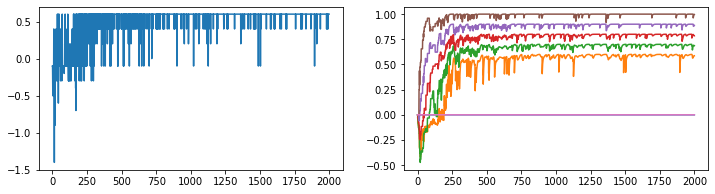

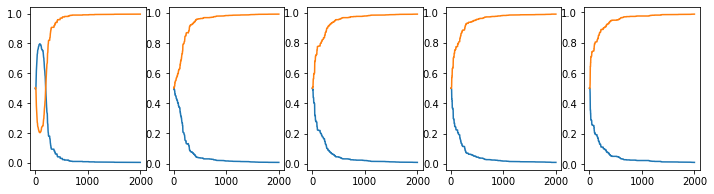

In [17]:
_, (axR, axV) = plt.subplots(ncols=2, figsize=(12,3))
axR.plot(hist_R)
axV.plot(hist_val)
plt.show()
_, axes = plt.subplots(ncols=5, figsize=(12,3))
for i, ax in enumerate(axes, start=1):
    ax.plot(hist_prob[:,i])
plt.show()

### SARSA

In [14]:
Q, N, hist_R, hist_Q, hist_prob = sarsa(env, 2000, gamma=1., alpha=.5, eps=.1)

hist_val = np.sum(hist_Q * hist_prob, axis=-1)
print('Average reward during second half:', np.average(hist_R[-1000:]))

Average reward during second half: 0.5203


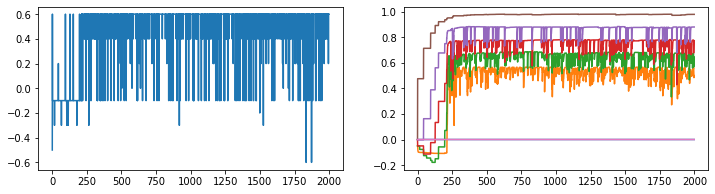

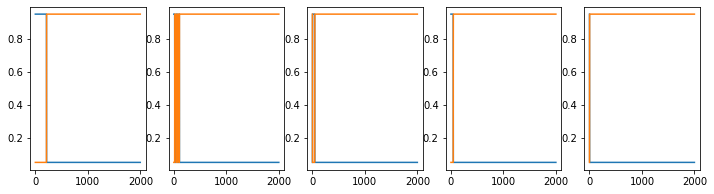

In [15]:
_, (axR, axV) = plt.subplots(ncols=2, figsize=(12,3))
axR.plot(hist_R)
axV.plot(hist_val)
plt.show()
_, axes = plt.subplots(ncols=5, figsize=(12,3))
for i, ax in enumerate(axes, start=1):
    ax.plot(hist_prob[:,i])
plt.show()

# Solve CliffWalking

In [14]:
env = CliffWalkingEnv()

Plotting helper

In [22]:
def plot_hist_grid(hist_arr, title, y_lim):
    nb_x, nb_y = hist_arr.shape[1], hist_arr.shape[2]
    
    fig, axes = plt.subplots(ncols=nb_x, nrows=nb_y, figsize=(16,4))
    for x in range(nb_x):
        for y in range(nb_y):
            ax = axes[nb_y-y-1, x]
            ax.plot(hist_arr[:,x,y])
            if y != 0:
                ax.set_xticks([], [])
            if x != 0:
                ax.set_yticks([], [])
            ax.set_ylim(y_lim)
    fig.suptitle(title)
    plt.show()

### One-Step Actor-Critic

In [15]:
hist_R_ac, hist_V_ac, hist_P_ac = one_step_actor_critic(
    env, ep=5000, gamma=1.0, alpha_w=2**-9, alpha_theta=2**-8)

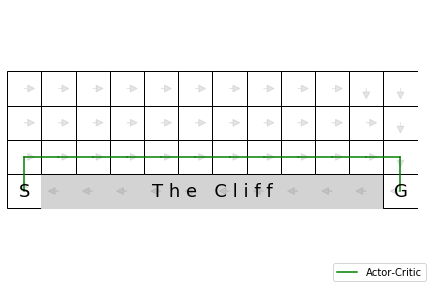

In [21]:
path_ac = env.get_path(hist_P_ac[-1])
plot_cliffwalk(hist_P_ac[-1], paths=[path_ac], colors=['green'], labels=['Actor-Critic'])

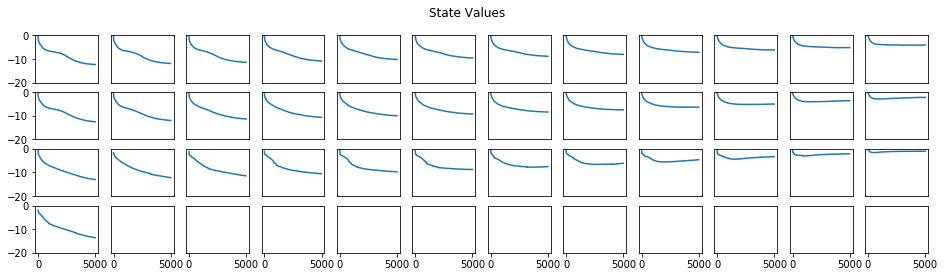

In [23]:
plot_hist_grid(hist_V_ac, title='State Values', y_lim=(-20, 0))

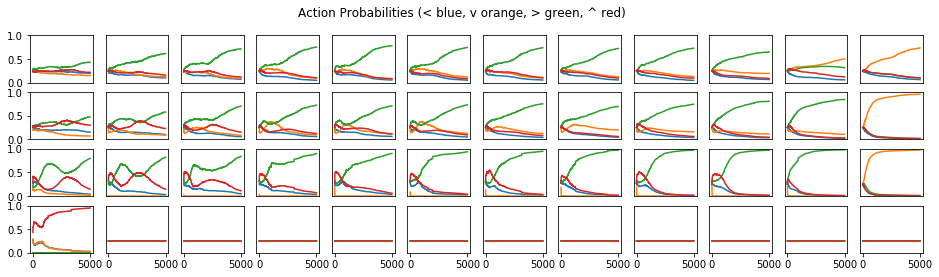

In [24]:
plot_hist_grid(hist_P_ac, title='Action Probabilities (< blue, v orange, > green, ^ red)', y_lim=(0, 1))

### SARSA

In [42]:
_, _, hist_R_sr, hist_Q_sr, hist_P_sr = sarsa(env, 5000, gamma=1., alpha=.5, eps=.1)
hist_V_sr = np.sum(hist_Q_sr * hist_P_sr, axis=-1)

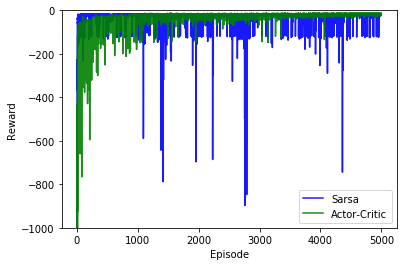

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(hist_R_sr, color='blue', label='Sarsa', alpha=.9)
ax.plot(hist_R_ac, color='green', label='Actor-Critic', alpha=.9)
ax.set_ylim(-1000, 0)
ax.set_ylabel('Reward')
ax.set_xlabel('Episode')
plt.legend()
plt.show()

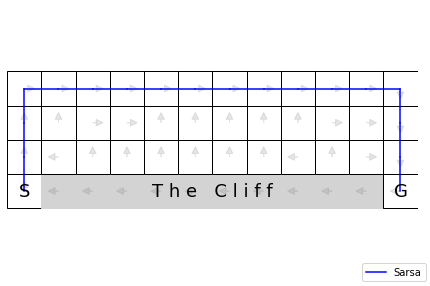

In [44]:
path_sr = env.get_path(hist_P_sr[-1])
plot_cliffwalk(hist_P_sr[-1], paths=[path_sr], colors=['blue'], labels=['Sarsa'])

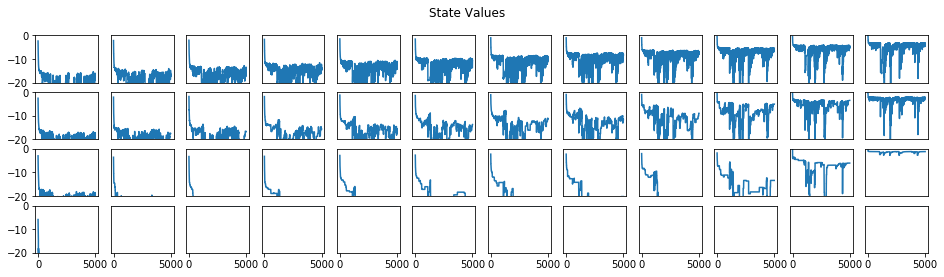

In [45]:
plot_hist_grid(hist_V_sr, title='State Values', y_lim=(-20, 0))

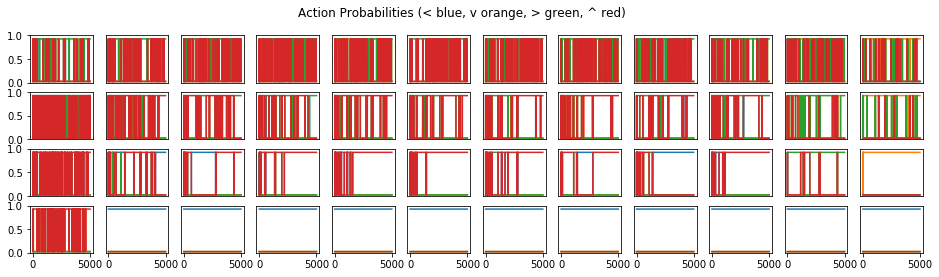

In [46]:
plot_hist_grid(hist_P_sr, title='Action Probabilities (< blue, v orange, > green, ^ red)', y_lim=(0, 1))

### Compare Algorithms

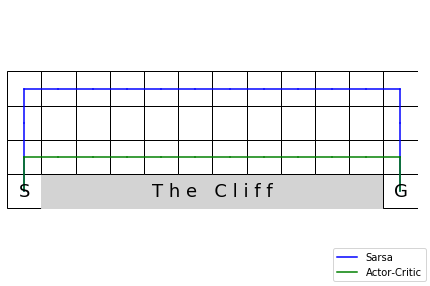

In [54]:
plot_cliffwalk(None,
               paths=[path_sr, path_ac],
               colors=['blue', 'green'],
               labels=['Sarsa', 'Actor-Critic'],
               saveimg='assets/fig_one_step_actor_critic.png')